# Streaming Anomaly Detection on Stock Data with TurboML

This notebook demonstrates how to perform **real-time anomaly detection** using [TurboML](https://turboml.com/) on stock data fetched from **Alpha Vantage**.

We will:
1. Fetch stock price and volume data from Alpha Vantage (using their **intraday** endpoint as an example).
2. Ingest data into TurboML in a push-based manner.
3. Create feature transformations (SQL feature and a rolling aggregation) that will be computed **continuously**.
4. Deploy an **unsupervised** **Random Cut Forest (RCF)** model to detect anomalies in real time.

Set up the environment and install TurboML's SDK.

In [ ]:
!pip install turboml-installer 
import turboml_installer ; turboml_installer.install_on_colab()

## 1. Install and Import Required Libraries
Alpha Vantage also requires an API key. You can sign up for a [free API key here](https://www.alphavantage.co/support/#api-key).

In [65]:
import turboml as tb
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

tb.init(backend_url=BACKEND_URL, api_key=API_KEY)

## 2. Fetch Stock Data from Alpha Vantage
We'll implement a helper function that fetches **intraday** data for a given symbol at a 1-minute interval (or any interval your Alpha Vantage plan supports).  
We will parse the response into a pandas DataFrame with columns: `[timestamp, symbol, price, volume]`.  

> **Important:** Replace `YOUR_ALPHA_VANTAGE_API_KEY` with your actual key.

In [66]:
# Replace with your actual Alpha Vantage API key
ALPHA_VANTAGE_API_KEY = "YOUR_ALPHA_VANTAGE_API_KEY"

def fetch_intraday_data(symbol="IBM", interval="1min", output_size="full"):
    """
    Fetch intraday stock data from Alpha Vantage for the given symbol.
    interval can be '1min', '5min', '15min', '30min', or '60min'.
    Returns a pandas DataFrame with columns:
       [timestamp, symbol, price, volume]
    """
    # Alpha Vantage Intraday API endpoint
    url = (
        f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY"
        f"&symbol={symbol}&interval={interval}&apikey={ALPHA_VANTAGE_API_KEY}"
        f"&outputsize={output_size}"
    )

    response = requests.get(url)
    data_json = response.json()

    # The JSON structure has a 'Time Series (1min)' key (or similar) that contains a dictionary of times
    time_series_key = f"Time Series ({interval})"
    if time_series_key not in data_json:
        print("Error fetching data. Response:", data_json)
        return pd.DataFrame([])

    ts_data = data_json[time_series_key]

    # Each key in ts_data is a timestamp, and the value is a dict with '1. open', '2. high', '3. low', '4. close', '5. volume'
    records = []
    for ts, vals in ts_data.items():
        # We can use the '4. close' price as a representative price
        price = float(vals['4. close'])
        volume = float(vals['5. volume'])
        records.append({
            "timestamp": pd.to_datetime(ts).value // 10**9,  # Convert to epoch seconds
            "symbol": symbol,
            "price": price,
            "volume": volume
        })

    df = pd.DataFrame(records)
    # Sort by timestamp ascending
    df = df.sort_values(by="timestamp").reset_index(drop=True)
    return df


### Test Data Fetch
Let's do a quick test fetch. We'll fetch intraday data points (Alpha Vantage returns whatever is available in their 'compact' data set, typically 100 data points).

In [67]:
# Example: fetch data for IBM at 1-minute intervals
df_fetched = fetch_intraday_data("IBM", "1min")
df_fetched.head()

,timestamp,symbol,price,volume
0,1732852800,IBM,227.00,22.0
1,1732852860,IBM,227.01,2.0
2,1732852920,IBM,227.01,9.0
3,1732852980,IBM,227.11,17.0
4,1732853040,IBM,227.48,8.0


## 3. Ingest Data into TurboML
We'll use TurboML’s **push-based ingestion** approach by uploading the pandas DataFrame via **`tb.PandasDataset`**.  
We’ll name the dataset `finance_data_av`.  

> **Note:** Since timestamps are unique to each minute in this dataset, we can use **`timestamp`** as the primary key for simplicity.

In [68]:
# Create a new dataset in TurboML
# We'll assume you already have a TurboML instance running
finance_dataset = tb.PandasDataset(
    dataset_name="finance_data_av",
    dataframe=df_fetched,
    key_field="timestamp",
    upload=True  # This actually uploads to TurboML
)
finance_dataset

INFO:turboml.common.dataloader:Uploading 12288 rows to dataset finance_data_av
Progress: 100%|██████████| 12.3k/12.3k [00:00<00:00, 35.6krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.


PandasDataset(dataset_id=finance_data_av, key_field=timestamp, feature_engineering=<turboml.common.feature_engineering.FeatureEngineering object at 0x7b226ce71110>, streaming=True, schema=id=1 schema_type=<SchemaType.PROTOBUF: 'PROTOBUF'> schema_body='syntax = "proto2";\nmessage finance_data_av {\noptional int64 timestamp = 1;\noptional string symbol = 2;\noptional double price = 3;\noptional double volume = 4;\n}', input_df=        timestamp symbol     price  volume
0      1732852800    IBM  227.0000    22.0
1      1732852860    IBM  227.0100     2.0
2      1732852920    IBM  227.0100     9.0
3      1732852980    IBM  227.1100    17.0
4      1732853040    IBM  227.4800     8.0
...           ...    ...       ...     ...
12283  1735328820    IBM  222.9000     2.0
12284  1735329000    IBM  222.7450     2.0
12285  1735329060    IBM  222.5542    66.0
12286  1735329180    IBM  222.5000     6.0
12287  1735329240    IBM  222.5122     2.0

[12288 rows x 4 columns])

In [69]:
df_input = finance_dataset.feature_engineering.get_materialized_features()
dummy_label_df = pd.DataFrame({
    "timestamp": df_input["timestamp"],      # match on your key field
    "dummy_label": [0]*len(df_input)         # fill with zeros (or None)
})
#Upload to TurboML
dummy_label_dataset = tb.PandasDataset(
    dataset_name="dummy_label_dataset",
    key_field="timestamp",
    dataframe=dummy_label_df,
    upload=True
)
#Get label field from dummy dataset
dummy_label_field = dummy_label_dataset.get_label_field(label_field="dummy_label")

INFO:turboml.common.dataloader:Uploading 12288 rows to dataset dummy_label_dataset
Progress: 100%|██████████| 12.3k/12.3k [00:00<00:00, 29.4krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.


## 4. Feature Engineering
We’ll create:
1. A **SQL feature** that multiplies `price * volume`.
2. A **rolling aggregation** (time-windowed) for the last 1 hour to sum volumes.

### 4.1 Register Timestamp
We must let TurboML know which column is used as the time column for streaming aggregations.

In [70]:
finance_dataset.feature_engineering.register_timestamp(
    column_name="timestamp",   # Our existing column
    format_type="epoch_seconds"  # The data is in epoch seconds
)

# Quick demonstration of time formats if needed
# print(tb.get_timestamp_formats())

### 4.2 SQL Feature
We'll create a new column called `price_volume_prod` which is simply `price * volume`.

In [71]:
finance_dataset.feature_engineering.create_sql_features(
    sql_definition='"price" * "volume"',
    new_feature_name="price_volume_prod"
)

### 4.3 Rolling Aggregation
We'll create a 1-hour rolling sum of volume per symbol.  
> For intraday data, 1 hour may or may not be relevant, but this is just a demonstration of windowed aggregation in TurboML.

In [72]:
finance_dataset.feature_engineering.create_aggregate_features(
    column_to_operate="volume",        # The field we want to aggregate
    column_to_group="symbol",         # Group by symbol
    operation="SUM",
    new_feature_name="rolling_volume_1h",
    timestamp_column="timestamp",
    window_duration=1,                 # Window size is 1 hour
    window_unit="hours"               # 'minutes' or 'hours' or 'days'
)

### 4.4 Materialize Features
Now, let's tell TurboML to actually compute these features continuously.  
Once materialized, these columns (`price_volume_prod`, `rolling_volume_1h`) will automatically update whenever new data arrives.

In [73]:
finance_dataset.feature_engineering.materialize_features([
    "price_volume_prod",
    "rolling_volume_1h"
])

df_local = finance_dataset.feature_engineering.get_materialized_features()
print("A snapshot of the materialized data:")
df_local.head(10)

A snapshot of the materialized data:


,timestamp,symbol,price,volume,price_volume_prod,rolling_volume_1h
0,1732852800,IBM,227.00,22.0,4994.00,22.0
1,1732852860,IBM,227.01,2.0,454.02,24.0
2,1732852920,IBM,227.01,9.0,2043.09,33.0
3,1732852980,IBM,227.11,17.0,3860.87,50.0
4,1732853040,IBM,227.48,8.0,1819.84,58.0
5,1732853100,IBM,227.03,19.0,4313.57,77.0
6,1732853160,IBM,227.40,1.0,227.40,78.0
7,1732853220,IBM,227.48,2.0,454.96,80.0
8,1732853280,IBM,227.08,2.0,454.16,82.0
9,1732853340,IBM,227.48,66.0,15013.68,148.0


## 5. Deploy an Anomaly Detection Model
We'll use **Random Cut Forest (RCF)**, which is good for unsupervised outlier/anomaly detection.  
### 5.1 Choose the Input Fields
We’ll pick numeric fields (`price, volume, price_volume_prod, rolling_volume_1h`) for RCF.

In [74]:
rcf_model = tb.RCF(number_of_trees=50)

# Which fields from our dataset do we want to feed into the model?
numerical_fields = ["price", "volume", "price_volume_prod", "rolling_volume_1h"]
model_inputs = finance_dataset.get_input_fields(numerical_fields=numerical_fields)

# Deploy the model. (Unsupervised, labels are not needed but the topics needs to be in pipeline)
deployed_rcf = rcf_model.deploy(
    name="streaming_finance_anomaly_detector",
    input=model_inputs,
    labels=dummy_label_field
)

## 6. Continuous Streaming Components

We'll implement functions to continuously fetch and process stock data from Alpha Vantage.

### 6.1 Stream Data Generator
First, let's create a function that yields chunks of stock data:

In [75]:
def stream_stock_data(symbol="IBM", interval="1min", chunk_size=10, delay=5):
    """Continuously fetch and stream stock data in chunks"""
    while True:
        try:
            df = fetch_intraday_data(symbol, interval)
            if df.empty:
                print("No data received, waiting before retry...")
                time.sleep(delay)
                continue

            for i in range(0, len(df), chunk_size):
                chunk = df.iloc[i:i+chunk_size]
                yield chunk

            time.sleep(delay)

        except Exception as e:
            print(f"Error fetching data: {e}")
            time.sleep(delay)

### 6.2 Data Upload Handler
Next, we'll create a handler for uploading data using TurboML's SDK:

In [76]:
def sdk_upload_df(dataset, df):
    """Upload data using TurboML SDK"""
    dataset.upload_df(dataframe=df)

### 6.3 Streaming Process
Now we'll create the main streaming function to handle continuous data processing

In [77]:
def run_continuous_streaming(finance_dataset, chunk_size=10, delay=5):
    """Stream stock data continuously to TurboML"""
    stream = stream_stock_data(chunk_size=chunk_size, delay=delay)

    with tqdm(desc="Streaming Progress") as pbar:
        try:
            for chunk in stream:
                start = time.perf_counter()
                sdk_upload_df(finance_dataset, chunk)
                end = time.perf_counter()

                pbar.update(len(chunk))
                print(f"Uploaded {len(chunk)} records in {end - start:.3f} seconds")

                # Monitor features and model outputs
                finance_dataset.sync_features()
                materialized = finance_dataset.feature_engineering.get_materialized_features()
                print("Latest materialized features shape:", materialized.shape)

                if deployed_rcf:
                    outputs = deployed_rcf.get_outputs()
                    if outputs:
                        print("Latest anomaly score:", outputs[-1]["record"].score)

        except KeyboardInterrupt:
            print("\nStreaming stopped by user")

### 6.4 Start Streaming
Let's configure and initiate the streaming process

In [78]:
CHUNK_SIZE = 10  # Records per batch
STREAM_DELAY = 5 # Seconds between API calls

print(f"""
Streaming Configuration:
- Chunk Size: {CHUNK_SIZE} records
- Delay between API calls: {STREAM_DELAY} seconds
- Upload method: SDK
- Model monitoring: Enabled
""")

run_continuous_streaming(
    finance_dataset,
    chunk_size=CHUNK_SIZE,
    delay=STREAM_DELAY
)


Streaming Configuration:
- Chunk Size: 10 records
- Delay between API calls: 5 seconds
- Upload method: SDK
- Model monitoring: Enabled



Streaming Progress: 0it [00:00, ?it/s]INFO:turboml.common.dataloader:Uploading 10 rows to dataset finance_data_av

Progress: 100%|██████████| 10.0/10.0 [00:00<00:00, 2.16krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.
Streaming Progress: 10it [00:08,  1.12it/s]

Uploaded 10 records in 1.622 seconds
Latest materialized features shape: (12288, 6)


INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 1 seconds
INFO:turboml.common.dataloader:Yielded 12288 records (3 batches) in 2 seconds


Latest anomaly score: 0.6437745690345764


INFO:turboml.common.dataloader:Uploading 10 rows to dataset finance_data_av

Progress: 100%|██████████| 10.0/10.0 [00:00<00:00, 1.44krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.
Streaming Progress: 20it [00:17,  1.15it/s]

Uploaded 10 records in 1.592 seconds
Latest materialized features shape: (12288, 6)


INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 1 seconds
INFO:turboml.common.dataloader:Yielded 12288 records (3 batches) in 2 seconds


Latest anomaly score: 0.6437745690345764


INFO:turboml.common.dataloader:Uploading 10 rows to dataset finance_data_av

Progress: 100%|██████████| 10.0/10.0 [00:00<00:00, 1.66krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.
Streaming Progress: 30it [00:26,  1.14it/s]

Uploaded 10 records in 1.571 seconds
Latest materialized features shape: (12288, 6)


INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 1 seconds
INFO:turboml.common.dataloader:Yielded 12288 records (3 batches) in 2 seconds


Latest anomaly score: 0.6437745690345764


INFO:turboml.common.dataloader:Uploading 10 rows to dataset finance_data_av

Progress: 100%|██████████| 10.0/10.0 [00:00<00:00, 7.13krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.
Streaming Progress: 40it [00:34,  1.15it/s]

Uploaded 10 records in 1.572 seconds
Latest materialized features shape: (12288, 6)


Streaming Progress: 40it [00:39,  1.01it/s]


Streaming stopped by user


## 7. Inspect Real-Time Outputs
Once deployed, the model processes all existing (and future) records in `finance_data_av`.  
We can call `get_outputs()` to see how many results have been generated so far and to view anomaly scores.

INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 1 seconds
INFO:turboml.common.dataloader:Yielded 12288 records (3 batches) in 2 seconds


Number of outputs so far: 12288
Sample output: {'offset': 12287, 'record': key: "1735329240"
score: 0.643774569
feature_score: 2.68710155e-05
feature_score: 0.000121300043
feature_score: 0.0267220289
feature_score: 0.973129749
}


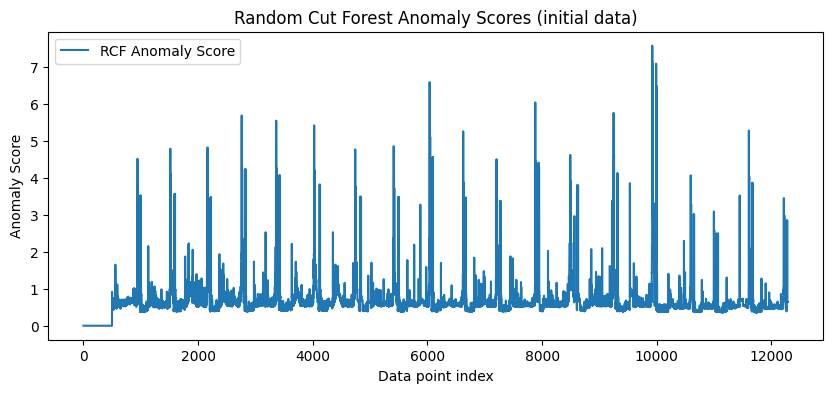

In [79]:
outputs = deployed_rcf.get_outputs()
print(f"Number of outputs so far: {len(outputs)}")
if len(outputs) > 0:
    print("Sample output:", outputs[-1])

# Let's plot the anomaly scores for all points we have
if len(outputs) > 0:
    anomaly_scores = [o["record"].score for o in outputs]
    plt.figure(figsize=(10, 4))
    plt.plot(anomaly_scores, label="RCF Anomaly Score")
    plt.title("Random Cut Forest Anomaly Scores (initial data)")
    plt.xlabel("Data point index")
    plt.ylabel("Anomaly Score")
    plt.legend()
    plt.show()

Most stock activity shows normal patterns with scores between 0-2. However, there are several significant spikes reaching scores of 4-7, indicating moments of unusual market behavior that could represent important trading signals or risk events. The most notable anomaly spike reaches approximately 7.5, marking the most unusual event in the dataset.

## 8. (Optional) Single-Record Inference via Model Endpoint
Instead of streaming, you might want to do **synchronous** (request-response) inference for a single data point.  
TurboML exposes a REST endpoint for each deployed model.  
We can get the endpoint URL via `get_endpoints()`.**bold text**

In [ ]:
model_endpoints = deployed_rcf.get_endpoints()
model_endpoints

### Example of a synchronous inference call
```python
test_point = {
    "timestamp": int(time.time()),
    "symbol": "IBM",
    "price": 135.12,
    "volume": 3000
}
# Make a POST request
predict_url = model_endpoints[0]  # e.g. 'https://<BASE_URL>/streaming_finance_anomaly_detector/predict'
resp = requests.post(predict_url, json=test_point, headers=tb.common.api.headers)
print("Response:", resp.json())
```

## 9. Drift Detection
TurboML can **continuously** monitor drift in your dataset and model outputs. We'll register **univariate** drift on `price` (for demonstration) and **model drift** on the RCF output.

### 9.1 Univariate Drift
We'll track changes in the distribution of `price`. (You could also do `volume`, `price_volume_prod`, etc.)

In [81]:
finance_dataset.register_univariate_drift(numerical_field="price")

To **fetch** univariate drift results, we can call:
```python
drift_price = finance_dataset.get_univariate_drift(numerical_field="price")
```
Each record has a `score` attribute.

INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 1 seconds
INFO:turboml.common.dataloader:Yielded 12288 records (3 batches) in 2 seconds


Number of univariate drift records for 'price': 12288


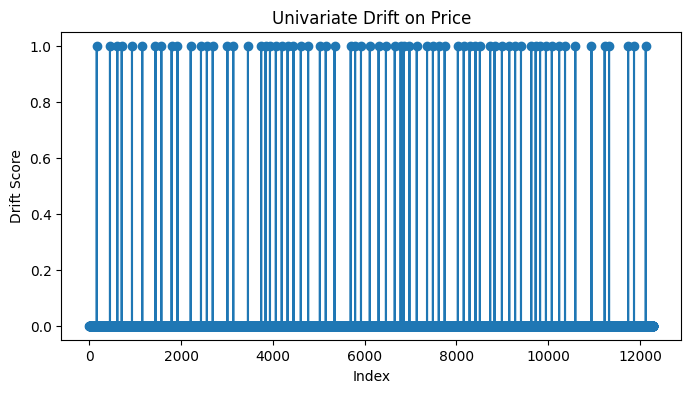

In [82]:
drift_price = finance_dataset.get_univariate_drift(numerical_field="price")
print(f"Number of univariate drift records for 'price': {len(drift_price)}")

def plot_drift(drifts, title="Univariate Drift", figsize=(8,4)):
    plt.figure(figsize=figsize)
    scores = [d["record"].score for d in drifts]
    plt.plot(scores, marker="o")
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Drift Score")
    plt.show()

if drift_price:
    plot_drift(drift_price, title="Univariate Drift on Price")

It shows a binary pattern where the price drift score alternates between 0 and 1, suggesting distinct shifts in price levels rather than gradual changes. These sharp transitions indicate moments when the stock price moves significantly from its previous distribution pattern, potentially representing important price level breakouts.

### 9.2 Model Drift
Similarly, we can detect changes in the distribution of the model's output (the RCF anomaly score).  
We'll add drift detection to the deployed model by calling:
```python
deployed_rcf.add_drift()
```
Then we can fetch those drift records with:
```python
drift_model = deployed_rcf.get_drifts()
```

In [83]:
deployed_rcf.add_drift()
print("Model output drift registered.")

drift_model = deployed_rcf.get_drifts()
print("Number of model drift records:", len(drift_model))

if drift_model:
    plot_drift(drift_model, title="Drift in Model Output (RCF)")

Model output drift registered.


INFO:turboml.common.dataloader:Yielded 0 records (0 batches) in 1 seconds


Number of model drift records: 0


Similar to univariate drift, the model drift score is consistently around 0, which means the distribution of the model’s outputs (the RCF anomaly scores) has remained stable. There is no substantial evidence that the model is encountering drastically different data than it was trained or initialized on.

## 10.Model Evaluation

In [ ]:
deployed_rcf.add_metric("WindowedAUC")
model_auc_scores = deployed_rcf.get_evaluation("WindowedAUC")
print("Number of AUC records:", len(model_auc_scores))

def plot_metric(scores, title="Windowed AUC", figsize=(8,4)):
    plt.figure(figsize=figsize)
    vals = [s.metric for s in scores]
    plt.plot(vals, marker="o", color="green")
    plt.title(title)
    plt.xlabel("Data point index")
    plt.ylabel("AUC")
    plt.ylim([0,1])
    plt.show()

if model_auc_scores:
  plot_metric(model_auc_scores, title="Windowed AUC over time")

## 11. Cleanup (Optional)
If you want to **delete** your deployed model and its outputs:
```python
# deployed_rcf.delete()
# This will remove the model and its output data.
```

From here, you can:
- Build more sophisticated features (e.g., [Python UDFs](https://docs.turboml.ai/feature-engineering.html#python-udf)).
- Add **model evaluation** metrics if you have ground-truth labels for anomalies.
- Use advanced **trigger-based updates** to re-train your model only when drift or performance issues are detected.
- Integrate with alerts or dashboards for outlier (and drift) monitoring in real time.

Happy streaming!  
**- The TurboML Team**